In [194]:
import pypsa
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd

### Import old and new grid extract for validation

For the current validation of the grid extract the *old grid extract* of commit *8dafb7bc838e046d28da94583164c349851915ba* and the *new grid extract* of commit *4becc4012fa7e30011a4ed230e2ccf83f1bbdece* is taken.

In [93]:
n=dict()
n["new"]=pypsa.Network("../networks/base_new.nc")
n["old"]=pypsa.Network("../networks/base_old.nc")
countries = gpd.read_file('../resources/country_shapes.geojson')

INFO:pypsa.io:Imported network base_new.nc has buses, lines, links, transformers
INFO:pypsa.io:Imported network base_old.nc has buses, lines, links, transformers


### Analyze graphs with networkx
Graphs for lines and links

In [103]:
edges=dict()
graph=dict()
for key in n.keys():
    lines=n[key].lines.loc[:,["bus0","bus1"]].reset_index().rename({"Line":"name"}, axis=1)
    lines["type"]="line"
    links=n[key].links.loc[:,["bus0","bus1"]].reset_index().rename({"Link":"name"}, axis=1)
    links["type"]="links"
    transformers=n[key].transformers.loc[:,["bus0","bus1"]].reset_index().rename({"Transformer":"name"}, axis=1)
    transformers["type"]="transformers"
    edges=pd.concat([lines,links,transformers], ignore_index=True)
    graph[key]=nx.convert_matrix.from_pandas_edgelist(edges, source="bus0", target="bus1",edge_attr=["name","type"])

Add node data to the networkx graph with "x" and "y" location of the corresponding node (bus)

In [105]:
for key in n.keys():
    nodes=graph[key].nodes
    nodes_df=n[key].buses.loc[list(nodes)]
    coordinates=[row.to_dict() for index, row in nodes_df.iterrows()]
    node_data = dict(zip(graph[key].nodes, coordinates))
    nx.set_node_attributes(graph[key], node_data)

Function to plot the networkx graph

In [149]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
def plot_graph(G, extent=None, with_labels=False):
    nodes_df=pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={"projection": ccrs.PlateCarree()})
    if isinstance(extent, str) and extent in nodes_df.country.unique():
        filter=nodes_df.query("country==@extent")
        ax.set_extent([filter["x"].min()-1, filter["x"].max()+1, filter["y"].min()-1, filter["y"].max()+1], ccrs.PlateCarree())
    else:
        ax.set_extent([nodes_df["x"].min()-1, nodes_df["x"].max()+1, nodes_df["y"].min()-1, nodes_df["y"].max()+1], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN, color="steelblue")
    ax.add_feature(cartopy.feature.LAND, edgecolor="black", color="burlywood")
    ax.add_feature(cartopy.feature.BORDERS)
    coordinates = np.column_stack((nodes_df.x, nodes_df.y))
    positions = dict(zip(G.nodes, coordinates))
    
    nx.draw(G, ax=ax, pos=positions, node_size=20, node_color="black", edge_color="black", alpha=0.8, with_labels=with_labels)

Plot the graph for Spain

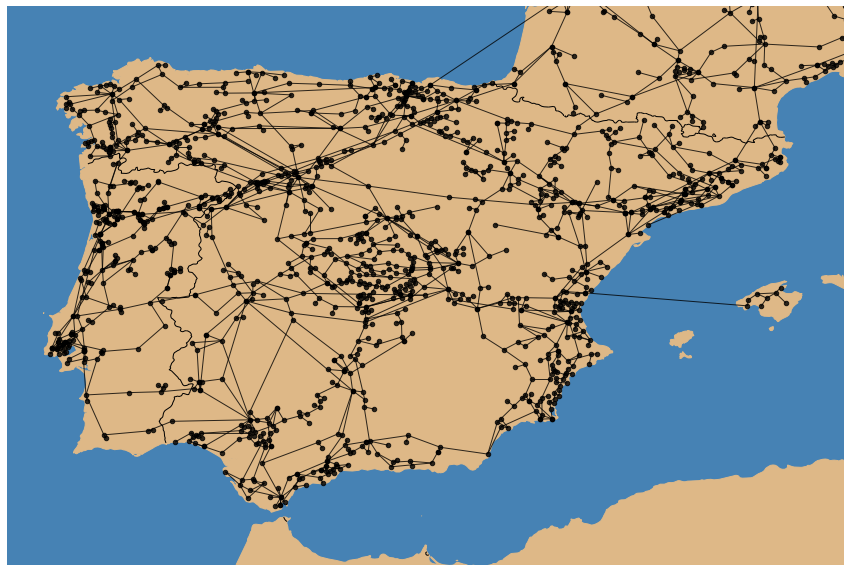

In [147]:
plot_graph(graph["new"], extent="ES")

Plot graph for europe

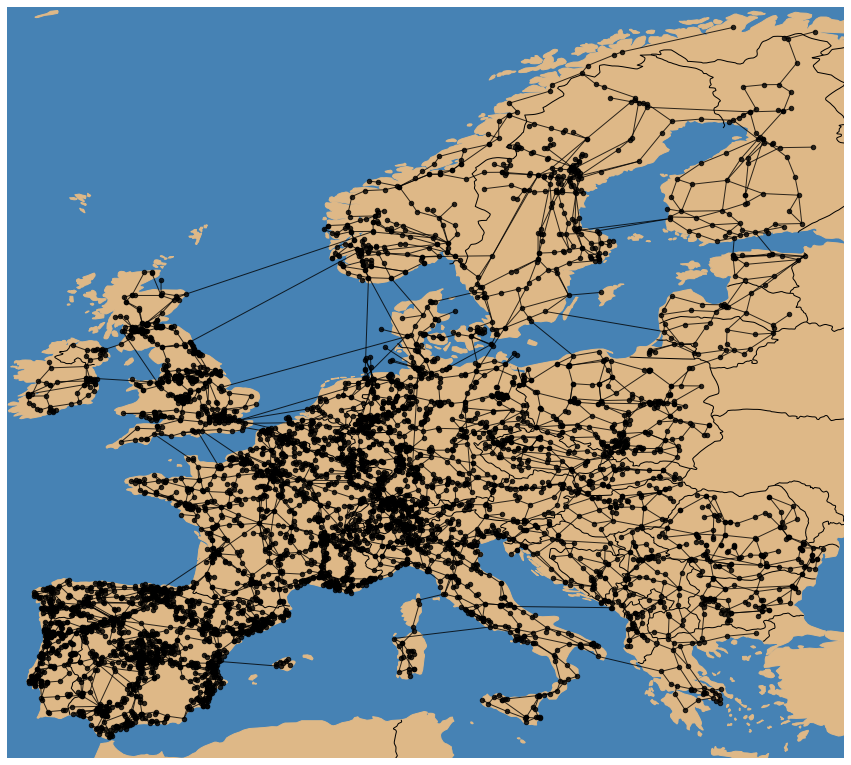

In [150]:
plot_graph(graph["new"])

Check if graph is connected

In [140]:
nx.is_connected(graph["new"])

True

## Get subgraphs from the original graph

In [144]:
subgraphs=dict()
for key in graph.keys():
    subgraphs[key] = [graph[key].subgraph(c).copy() for c in nx.connected_components(graph[key])]

Statistically describe how many nodes are within a subgraph.
Only relevant if graph is not connected

In [145]:
pd.DataFrame([len(s) for s in subgraphs["new"] ]).describe()

,0
count,1.0
mean,5399.0
std,NaN
min,5399.0
25%,5399.0
50%,5399.0
75%,5399.0
max,5399.0


## Check if neighbor nodes are connected

In [157]:
def nodes_connected(G ,source, target):
    return nx.has_path(G, source, target)

Gets the closest node to each node

In [164]:
from sklearn.neighbors import BallTree
nodes_df=pd.DataFrame.from_dict(dict(graph["new"].nodes(data=True)), orient='index')
tree=BallTree(nodes_df[["x","y"]].values, metric="haversine")
dist,ind=tree.query(nodes_df[["x","y"]].values, k=2)
closest_node=dict()
for i in range(len(nodes_df)):
    closest_node.update({nodes_df.iloc[i].name:nodes_df.iloc[ind[i,1]].name})

Checks if there is a path to the closest node. If true, there is a path.

In [166]:
nodes_connected_list=[nodes_connected(graph["new"], key, value) for key, value in closest_node.items() if key!=value]

Count nodes which are not connected

In [167]:
nodes_connected_list.count(False)

0

## Plot overlay of old grid extract and new grid extract

In [268]:
def plot_grid_overlay(extent=None):
        fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'projection': ccrs.PlateCarree()})

        offset = 1

        if isinstance(extent, str) and extent in n["old"].buses.country.unique():
                bounds=[n["old"].buses.query("country==@extent").x.min()-offset, n["old"].buses.query("country==@extent").x.max()+offset,
                        n["old"].buses.query("country==@extent").y.min()-offset, n["old"].buses.query("country==@extent").y.max()+offset]
                countries.query("name==@extent").boundary.plot(ax=ax, color='black', alpha=1)
        else:
                bounds=None

        n["old"].plot(ax=ax, color_geomap=True,
                bus_sizes=1e-3, link_widths=8, line_widths=8, boundaries=bounds)
        n["new"].plot(ax=ax,  color_geomap=True,
                bus_colors='red', line_colors='red', link_colors='purple',
                bus_sizes=2e-4, link_widths=2, line_widths=2, boundaries=bounds)

        
        return fig


One can plot the grid for each country or whole Europe as an overlay with the old grid extract. The new grid extract has thin red AC lines and thin purple DC lines.

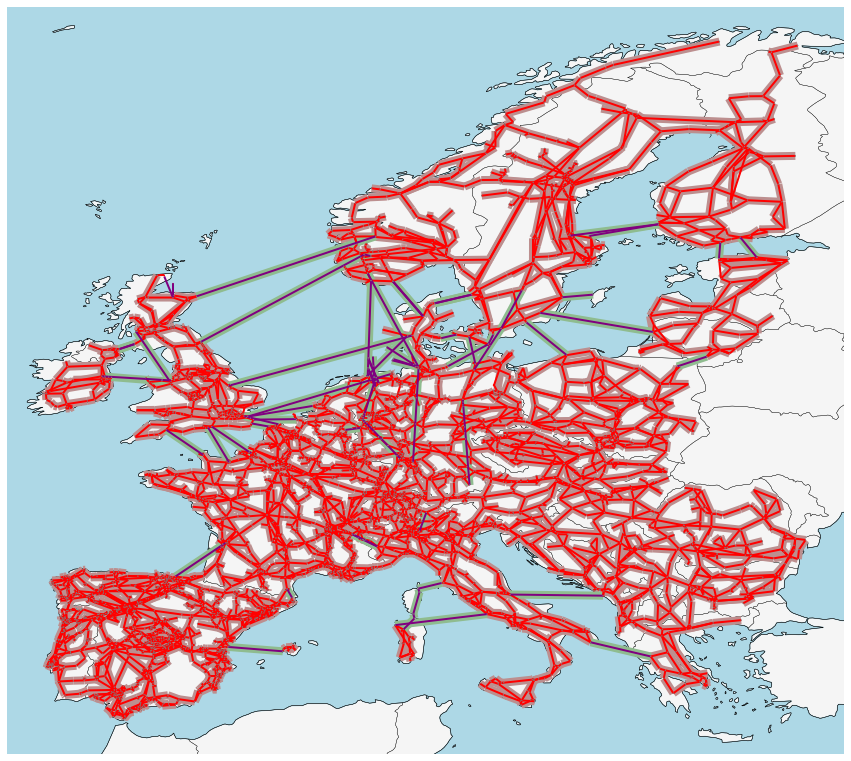

In [270]:
overlay=plot_grid_overlay()

## Check line strings length and length of line 

In [389]:
from shapely.wkt import loads
import re

In [331]:
line_gdf=gpd.GeoDataFrame(n["new"].lines.geometry.apply(lambda x: loads(x)), crs=4326)
line_gdf["length"]=line_gdf.to_crs(32633).length/1000

Get the ratio of the line string compared to the grid exract line length

In [332]:
ratio=line_gdf["length"]/n["new"].lines.length

If ratio of line_x is high this does not have to be a abnormality. Some line segments are split into various segments, however, they all share the same line string.

In [408]:
tolerance = 0.1

Lines where ratio is outside the tolerance ((1-tolerance) and (1+tolerance))

In [419]:
ratio[~(((1-tolerance)<ratio) & (ratio<(1+tolerance)))]

Line
4227          0.772970
539           1.196125
14676        26.252666
11302        10.198203
3576          1.515965
6066          1.360702
5837         23.962963
13009         6.330850
12976        18.618708
13218         1.393647
13217         1.183860
14258        38.484096
539_2        13.452022
3576_2       13.054560
3578_2       35.291074
4227_2        2.548955
4520_2     2970.341901
6066_2      213.391302
12898_2      19.134600
13009_2       4.344689
13217_2       1.168397
13218_2       1.375443
14676_2       1.122179
14748_2      13.702726
13009_3       4.734589
13009_4       1.441518
Name: length, dtype: float64

In [423]:
lines_to_check=ratio[~(((1-tolerance)<ratio) & (ratio<(1+tolerance)))].index

Check for lines outside of tolerance if error is due to line segments

In [482]:
length_mismatch=dict()
line_names_mismatch=list()
for line in lines_to_check:
    if "_" in line:
        line_name=line[:-2]
    else:
        line_name=line
    if line_name in length_mismatch.keys():
        continue
    r=re.compile("^"+line_name+"((_\d)?)$")
    filter=n["new"].lines.length.index.str.match(r)
    total_length=n["new"].lines.length[filter].sum()
    line_string_length =line_gdf["length"][line_name]
    if not(line_string_length * (1-tolerance) < total_length < line_string_length * (1+tolerance)):
        length_mismatch[line_name]={"string_length":line_string_length,"line_length":total_length, "no_segments":len(n["new"].lines[filter])}
        line_names_mismatch.append(n["new"].lines.length[filter].index.values)
        print(f"Line length of line {line_name} is diffrent by a tolerance of {tolerance} from its line string")
line_names_mismatch=list(np.concatenate(line_names_mismatch).flat)
    

Line length of line 4227 is diffrent by a tolerance of 0.1 from its line string
Line length of line 3576 is diffrent by a tolerance of 0.1 from its line string
Line length of line 6066 is diffrent by a tolerance of 0.1 from its line string
Line length of line 13009 is diffrent by a tolerance of 0.1 from its line string
Line length of line 13218 is diffrent by a tolerance of 0.1 from its line string
Line length of line 13217 is diffrent by a tolerance of 0.1 from its line string
Line length of line 12898 is diffrent by a tolerance of 0.1 from its line string


In [444]:
length_mismatch

{'4227': {'string_length': 7.678561363580587,
  'line_length': 12.946272942550932,
  'no_segments': 2},
 '3576': {'string_length': 27.652754624704183,
  'line_length': 20.359268358067105,
  'no_segments': 2},
 '6066': {'string_length': 152.98998968160518,
  'line_length': 113.15156221344861,
  'no_segments': 2},
 '13009': {'string_length': 18.115464058734553,
  'line_length': 23.42415806537224,
  'no_segments': 4},
 '13218': {'string_length': 12.630017809093072,
  'line_length': 18.24507464532375,
  'no_segments': 2},
 '13217': {'string_length': 10.72880806503491,
  'line_length': 18.24507464532375,
  'no_segments': 2},
 '12898': {'string_length': 10.964440854361586,
  'line_length': 12.111696032440129,
  'no_segments': 2}}

Create for graph from mismatched lines

In [485]:
line_edges=n["new"].lines.loc[line_names_mismatch,["bus0","bus1"]].reset_index()
line_graph=nx.convert_matrix.from_pandas_edgelist(line_edges, source="bus0", target="bus1",edge_attr="Line")
nodes=line_graph.nodes
nodes_df=n["new"].buses.loc[list(nodes)]
coordinates=[row.to_dict() for index, row in nodes_df.iterrows()]
node_data = dict(zip(line_graph.nodes, coordinates))
nx.set_node_attributes(line_graph, node_data)

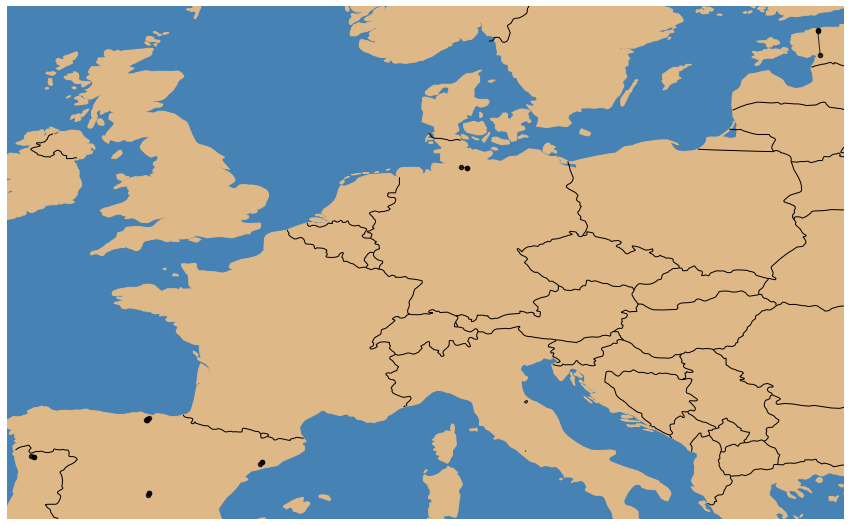

In [491]:
plot_graph(line_graph, with_labels=False)